<a href="https://colab.research.google.com/github/softmurata/colab_notebooks/blob/main/generative/stable_diffusion_inpainting_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade diffusers transformers accelerate
!git clone https://github.com/huggingface/diffusers.git
%cd diffusers/examples/research_projects/dreambooth_inpaint
!pip install -qq git+https://github.com/huggingface/diffusers.git
!pip install bitsandbytes

In [2]:
MODEL_NAME="stabilityai/stable-diffusion-2-inpainting"
INSTANCE_DIR = "/content/images"
OUTPUT_DIR="/content/results"

In [ ]:
!accelerate launch train_dreambooth_inpaint.py --pretrained_model_name=$MODEL_NAME --instance_data_dir=$INSTANCE_DIR --output_dir=$OUTPUT_DIR --instance_prompt="anya" --resolution=512 --train_batch_size=1 --gradient_accumulation_steps=2 --gradient_checkpointing --use_8bit_adam --learning_rate=5e-6 --lr_scheduler="constant" --lr_warmup_steps=0 --max_train_steps=800

In [4]:
#@title inference
import torch
from torch import autocast
from diffusers import StableDiffusionInpaintPipeline, DDIMScheduler

model_path=OUTPUT_DIR

scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
pipe = StableDiffusionInpaintPipeline.from_pretrained(model_path, scheduler=scheduler, safety_checker=None, torch_dtype=torch.float16).to("cuda")
g_cuda = None
 
# seed setting
g_cuda = torch.Generator(device='cuda')
seed = 52362 
g_cuda.manual_seed(seed)

In [5]:
# you should import woman.jpeg and woman_mask.png from local machine
from PIL import Image, ImageDraw

img_w, img_h = 512, 512
 
init_image = Image.open("/content/woman.jpeg").resize((img_w, img_h))
mask_image = Image.open("/content/woman_mask.png").resize((img_w, img_h))

In [8]:
# prompt
prompt = "anya" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
 
# other setting
num_samples = 1 
guidance_scale = 7.5 
num_inference_steps = 50 
height = 512 
width = 512
 
with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        image=init_image,
        mask_image=mask_image,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

  0%|          | 0/50 [00:00<?, ?it/s]

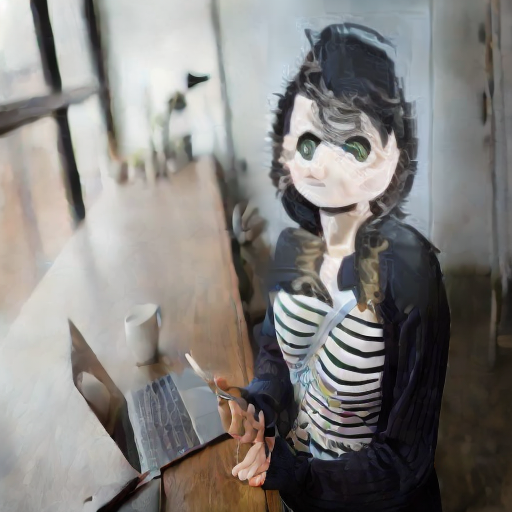

In [9]:
display(images[0])